# 1. Introduction

...

In [1]:
from functools import partial
import os
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import scipy.stats
from scipy.stats import norm as z
from skbio.stats.power import subsample_power, confidence_bound

from emp_power.power import subsample_power
import emp_power.traditional as trad
import emp_power.plot as plot
import emp_power.utils as ap

% matplotlib inline
sn.set_style('ticks')

# 2. Parameters

In [2]:
num_rounds = 100
sim_location = './simulations/'
if not os.path.exists(sim_location):
    raise ValueError('The simulations do not exist. Go back and simulate some data!')

In [3]:
overwrite = False

In [4]:
counts = np.arange(5, 100, 10)
alpha = 0.05
distributions = {}

# 3. Parametric Distributions

## 3.1 One Sample T test

A case I t-test checks if an observation is drawn from a sample. We are testing the alternatively hypotheses,

$\begin{matrix}
\textbf{H}_{0} & x = \bar{x} \\
\textbf{H}_{1} & x \neq \bar{x}\\
\end{matrix} \tag{2.1}$

where $\bar{x}$ is the mean of the population, $x$ is the value being compared to the sample, $s$ is the standard devation of the sample, and there are $n$ observations in the sample.

### 3.1.1 Test Statistic

The test statistic for the case I t test is given as
$t = \frac{(\bar{x} - x)\sqrt{n}}{s} \tag{2.2}$
The probability distribution follows a T distribution with $n-1$ degrees of freedom, where $n$ is the number of observations in the sample.


For the emperical test, we will use the `scipy.stats.ttest_1samp` function, which returns a p value.

In [5]:
def emp_ttest_1(sample, x0=0):
    return scipy.stats.ttest_1samp(sample[0], x0)[1]

### 3.1.2 Effect Size

The non centrality paramter for the statistic, $\lambda$ is given by
$\begin{align*}
\lambda &= \frac{t}{\sqrt{n}}\\
&=\frac{1}{\sqrt{n}}\left(\frac{(\bar{x} - x)\sqrt{n}}{s}\right )\\
&=\frac{(\bar{x} - x)}{s}
\end{align*}\tag{2.4}$

We will encorperate this in the power calculation. To allow for testing, the power calculation has been moved into a library.

In [6]:
distributions['ttest_1'] = {'test': emp_ttest_1,
                            'trad_power': partial(trad.calc_ttest_1, 
                                                  x0=0, 
                                                  counts=counts),
                            'empr_power': partial(subsample_power, 
                                                  counts=counts, 
                                                  num_iter=1000, 
                                                  num_runs=3,
                                                  test=emp_ttest_1)
                            }

## 3.2 Independent T test

The case II t test is a test for two independent samples, to determine if the samples are drawn from different distributions.

$\begin{matrix}
\textbf{H}_{0} & \bar{x}_{1} = \bar{x}_{2} \\
\textbf{H}_{1} & \bar{x}_{1} \neq \bar{x}_{2}\\
\end{matrix} \tag{3.1}$

### 3.2.1 Test Statistic

There are several ways to calculate this t statistic, but we will operate on the assumption that the two populations have different variances, giving the most extensibe calculation of the test statistic. So,

$\begin{align*}
t &= \frac{\bar{x}_{1} - \bar{x}_{2}}{\sqrt{\frac{s_{1}^{2}}{n_{1}} + \frac{s_{2}^{2}}{n_{2}}}}\\
&= \frac{\bar{x}_{1} - \bar{x}_{2}}{\sqrt{\frac{n_{2}s_{1}^{2} + n_{1}s_{2}^{2}}{n_{1}n_{2}}}}
\end{align*}\tag{3.2}$

The t statistic follows a T distribution with $df$ degrees of freedom, where $df$ is given as
$df = \frac{(s_{1}^{2}/n_{1} + s_{2}^{2}/n_{2})^{2}}{(s_{1}^{2}/n_{1})^2/(n_{1}-1) + s_{2}^{2}/n_{2})^2/(n_{2}-1)} \tag{3.3}$

For the sake of simplicity, we'll assume that $n_{1} = n_{2}$, which allows us to redefine equation (2.1) as
$\begin{align*}
t &= \frac{(\bar{x}_{1} - \bar{x}_{2})}{\sqrt{\frac{s_{1}^{2}}{n} + \frac{s_{2}^{2}}{n}}}\\
&= \frac{\sqrt{n}(\bar{x}_{1} - \bar{x}_{2})}{\sqrt{s_{1}^{2} + s_{2}^{2}}}
\end{align*}\tag{3.4}$
which means the test statitic is now drawn from a t distribution with df degrees of freedom, where
df is defined as
$\begin{align*}
df &= \left (n-1 \right ) \left (\frac{\left (s_{1}^{2} + s_{2}^{2}  \right )^{2}}{\left (s_{1}^{2} \right)^{2} + \left (s_{2}^{2}  \right )^{2}} \right )\\
\end{align*}\tag{3.5}$

For the emperical test, we can use the `scipy.stats.ttest_ind` function, which will return a p value.

For the sake of simplicity, we'll assume that $n_{1} = n_{2}$, which allows us to redefine equation (2.1) as
$\begin{align*}
t &= \frac{(\bar{x}_{1} - \bar{x}_{2})}{\sqrt{\frac{s_{1}^{2}}{n} + \frac{s_{2}^{2}}{n}}}\\
&= \frac{\sqrt{n}(\bar{x}_{1} - \bar{x}_{2})}{\sqrt{s_{1}^{2} + s_{2}^{2}}}
\end{align*}\tag{3.4}$
which means the test statitic is now drawn from a t distribution with df degrees of freedom, where
df is defined as
$\begin{align*}
df &= \left (n-1 \right ) \left (\frac{\left (s_{1}^{2} + s_{2}^{2}  \right )^{2}}{\left (s_{1}^{2} \right)^{2} + \left (s_{2}^{2}  \right )^{2}} \right )\\
\end{align*}\tag{3.5}$

For the emperical test, we can use the `scipy.stats.ttest_ind` function, which will return a p value.

In [7]:
def emp_ttest_ind(samples):
    sample1, sample2 = samples
    return scipy.stats.ttest_ind(sample1, sample2)[1]

### 3.2.2 Noncentrality Parameter

The effect size, non-centrality parameter, for an independent sample t test where samples are the same size is once again related to the test statistic as
$\begin{align*}
\lambda &= \frac{t}{\sqrt{n}}\\
&= \left (\frac{\sqrt{n} \left (\bar{x}_{1} - \bar{x}_{2} \right )}{\sqrt{s_{1}^{2} + s_{2}^{2}}} \right ) \left (\frac{1}{\sqrt{n}} \right )\\
&= \left (\frac{\bar{x}_{1}^{2} - \bar{x}_{2}^{2}}{\sqrt{s_{1}^{2} + s_{2}^{2}}} \right )
\end{align*}\tag{3.8}$

In [8]:
distributions['ttest_ind'] = {'test': emp_ttest_ind,
                              'trad_power': partial(trad.calc_ttest_ind, 
                                                    counts=counts),
                              'empr_power': partial(subsample_power, 
                                                  counts=counts, 
                                                  num_iter=1000, 
                                                  num_runs=3,
                                                  test=emp_ttest_ind)
                              }

## 3.3 One way Analysis of Variance

Assume there exist a set of samples, $\{S_{1}, S_{2}, ..., S_{k} \}$ where there are a total of $N$ observations distributed over the $k$ groups. The $i$th sample, $S_{i}$ contains $n_{i}$ observations, and has a mean of $\bar{x}_{.i}$ and a standard deviation, $s_{i}$ where

$\begin{align*}
s_{i} = \sqrt{\frac{\sum_{j=1}^{n}{\left (x_{ij} - \bar{x}_{.i} \right)^{2}}}{n_{i}-1}}
\end{align*}\tag{4.1}$

A one-way Analysis of Variance (ANOVA) tests that at least one sample mean in a set of three or more are not equal. Assume that 

$\begin{matrix}
\textbf{H}_{0} & \bar{x}_{1} = \bar{x}_{2} = ... \bar{x}_{k} & \\
\textbf{H}_{1} & \bar{x}_{i} \neq \bar{x}_{j} & \exists i,j \epsilon [1, k], i \neq j
\end{matrix} \tag{4.2}$

### 3.3.1 Test Statistic

Assume there exist a set of samples, $\{S_{1}, S_{2}, ..., S_{k} \}$ where there are a total of $N$ observations distributed over the $k$ groups. The $i$th sample, $S_{i}$ contains $n_{i}$ observations, and has a mean of $\bar{x}_{.i}$ and a standard deviation, $s_{i}$ where

$\begin{align*}
s_{i} = \sqrt{\frac{\sum_{j=1}^{n}{\left (x_{ij} - \bar{x}_{.i} \right)^{2}}}{n_{i}-1}}
\end{align*}\tag{4.1}$

A one-way Analysis of Variance (ANOVA) tests that at least one sample mean in a set of three or more are not equal. Assume that 

$\begin{matrix}
\textbf{H}_{0} & \bar{x}_{1} = \bar{x}_{2} = ... \bar{x}_{k} & \\
\textbf{H}_{1} & \bar{x}_{i} \neq \bar{x}_{j} & \exists i,j \epsilon [1, k], i \neq j
\end{matrix} \tag{4.2}$

The test statistic for ANOVA is given by
$\begin{align*}
F &= \frac{\frac{\textrm{SS}_{\textrm{between}}}{\textrm{DF}_{\textrm{between}}}}{\frac{\textrm{SS}_{\textrm{within}}}{\textrm{DF}_{\textrm{within}}}}
\end{align*}\tag{4.3}$
and test statistic is drawn from an $F$ distribution with $k - 1$ and $N - k$ degrees of freedom [[3](#Zar)].

For the emperical test, we can use the `scipy.stats.f_oneway` function, which will return a p value.

In [9]:
def emp_anova(samples):
    return scipy.stats.f_oneway(*samples)[1]

### 3.3.2 Noncentrality Parameter

Under the alternatively hypothesis, the non-centrality $F'$ is given by

$\begin{align*}
F' = \left(\frac{\textrm{SS}_{\textrm{between}}}{\textrm{SS}_{\textrm{within}}} \right) \left (\frac{\textrm{DF}_{\textrm{within}}}{\textrm{DF}_{\textrm{between}}}{} \right )
\end{align*}\tag{4.9}$

For a given pair of hypotheses, the noncentrality parameter is defined according to equation (2.4), where the grand mean can be substituted for the the test mean. The overall effect size is therefore given as
$\begin{align*}
\lambda &= \sum_{i=1}^{k}{\lambda_{i}^{2}}\\
&= \sum_{i=1}^{k}\left (\frac{\bar{x}_{i} - \bar{x}_{..}}{s_{i}} \right )^{2} 
\end{align*} \tag{4.10}$

Our simulations will focus on the 3 sample ANOVA we generated earlier.

In [10]:
distributions['anova_3'] = {'test': emp_anova,
                            'trad_power': partial(trad.calc_anova, 
                                                  counts=counts),
                            'empr_power': partial(subsample_power, 
                                                  counts=counts, 
                                                  num_iter=1000, 
                                                  num_runs=3,
                                                  test=emp_anova)
                              }
distributions['anova_8'] = {'test': emp_anova,
                            'trad_power': partial(trad.calc_anova, 
                                                  counts=counts),
                            'empr_power': partial(subsample_power, 
                                                  counts=counts, 
                                                  num_iter=1000, 
                                                  num_runs=3,
                                                  test=emp_anova)
                              }

## 3.4 Pearson's R

Pearson's correlation coeffecient looks for a linear one-to-one relationship between two vectors, $x$ and $y$, both of size $n$. Closely related vectors have a correlation coeffecient with an absloute value of 1, unrelated data have a correlation coeffecient of 0.

### 3.4.1 Test Statistic

The correlation coeffecient between the two vectors is given by
$\begin{align*}
r = \frac{\sum{xy}}{\sqrt{\sum{x^{2}}\sum{y^{2}}}}
\end{align*}\tag{5.1}$

We can test the hypotheses,
$\begin{matrix}
\textbf{H}_{0} & r = 0 \\
\textbf{H}_{1} & x \neq 0\\
\end{matrix} \tag{5.2}$
with a test statistic drawn from the $t$ distribution with $n - 2$ degrees of freedom. The statistic is calculated as
$\begin{align*}
t = \frac{r\sqrt{n-2}}{\sqrt{1 - r^{2}}}
\end{align*}\tag{5.3}$

Scipy's `scipy.stats.pearsonr` can calculate the correlation coeffecient *and* a p value for the coeffecient.

In [11]:
def emp_pearson(samples):
    return scipy.stats.pearsonr(*samples)[1]

### 3.4.2 Noncentrality Parameter

The noncentrality parameter for pearson's correlation coeffecient is given by
$\begin{align}
\lambda = \frac{r}{\sqrt{1 - r^{2}}}
\end{align}\tag{5.4}$

In [12]:
distributions['correlation'] = {'test': emp_pearson,
                                'trad_power': partial(trad.calc_pearson, 
                                                      counts=counts),
                                'empr_power': partial(subsample_power, 
                                                      counts=counts, 
                                                      num_iter=1000, 
                                                      num_runs=3,
                                                      draw_mode='matched',
                                                      test=emp_pearson)
                                }


# Power Calculations

We'll calculate 

In [13]:
%%time
summary = {}
for test_name in distributions.keys():
    # 
    summary[test_name] = {}
    # Checks the directory location
    sim_dir = os.path.join(sim_location, '%s/data/' % test_name)
    power_dir = os.path.join(sim_location, '%s/power/' % test_name)

    if os.path.exists(power_dir) and not overwrite:
        # Loads the power
        for i in range(num_rounds):
            with open(os.path.join(power_dir, 'simulation_%i.p' % i), 'rb') as f_:
                summary[test_name][i] = pickle.load(f_)
    else:
        # Creates the new directory
        if not os.path.exists(power_dir):
            os.makedirs(power_dir)
        
        # Generates the new power simulations
        trad_calc = distributions[test_name]['trad_power']
        emp_calc = distributions[test_name]['empr_power']
        test = distributions[test_name]['test']
        
        for i in range(num_rounds):
            # Loads the simulated data
            with open(os.path.join(sim_dir, 'simulation_%i.p' % i), 'rb') as f_:
                simulation = pickle.load(f_)
            samples = simulation['samples']
            traditional = trad_calc(*samples)
            emperical = emp_calc(samples=samples)
            round_summary = {'emperical_power': emperical,
                             'traditional': traditional,
                             'num_obs': len(samples[0]),
                             'original_p': test(samples)
                             }
            summary[test_name][i] = round_summary
            with open(os.path.join(power_dir, 'simulation_%i.p' % i), 'wb') as f_:
                pickle.dump(round_summary, f_)

CPU times: user 14.7 ms, sys: 5.16 ms, total: 19.9 ms
Wall time: 19.3 ms


Let's compare the simulated power with the traditionally defined power.

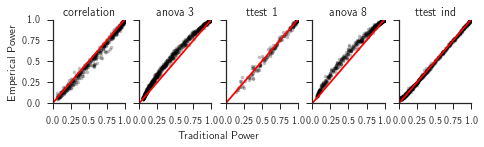

In [22]:
fig, axes = plt.subplots(1, 5)
fig.set_size_inches((8, 2))
correlations = {}
for idx, (test_name, ax) in enumerate(zip(*(distributions.keys(), axes))):
    test_data = pd.DataFrame.from_dict(summary[test_name], orient='index')
    
    emperical = np.hstack(test_data['emperical_power'].apply(lambda x: x.mean(0)))
    traditional = np.hstack(test_data['traditional'])
    
    ax.plot(traditional, emperical, 'k.', alpha=0.25)
    ax.plot([0, 1], [0, 1], 'r-')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_title(test_name.replace('_', ' '))
    
    sn.despine()
    
    ax.set_xticks(np.arange(0, 1.1, 0.25))
    ax.set_yticks(np.arange(0, 1.1, 0.25))
    ax.set_xticklabels(ax.get_xticks())
    ax.set_yticklabels('')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    
    m, b, r, p, s = scipy.stats.linregress(traditional, emperical)
    correlations[test_name] = {'slope': m,
                               'intercept': b,
                               'pearson': np.square(r),
                               's_error': s,
                               }


axes[0].set_yticklabels(axes[0].get_yticks())
axes[0].set_ylabel('Emperical Power')
xl = axes[1].set_xlabel('Traditional Power')
xl.set_position((1.1, 0.5))

fig.set_size_inches((7.5, 1.5))

In [20]:
pd.DataFrame.from_dict(correlations, orient='index')

,intercept,slope,s_error,pearson
anova_3,0.070737,0.961622,0.003297,0.988403
anova_8,0.113113,0.898279,0.003029,0.988781
correlation,-0.024734,1.018206,0.002476,0.994132
ttest_1,0.000319,0.999800,0.002294,0.994775
ttest_ind,0.018676,0.976403,0.001124,0.998680


We see a high degree of correlation between the traditional method and the emperical method, although some of the breakdown is seen in the ANOVA, espeically with 8 groups. However, the results are highly correlated ($R^{2} > 0.98$).

# Works Cited
